# NOTEBOOK TO REPRODUCE THE LEAVE-ONE-OUT TEST OF FORESTFLOW 

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [2]:
from ForestFlow.model_p3d_arinyo import ArinyoModel
from ForestFlow import model_p3d_arinyo
from ForestFlow.archive import GadgetArchive3D
from ForestFlow.P3D_cINN import P3DEmulator
from ForestFlow.likelihood import Likelihood


In [3]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"


## DEFINE FUNCTIONS

In [4]:
def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder

path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

/global/u1/l/lcabayol/P3D/ForestFlow/


In [5]:
def sigma68(data): return 0.5*(pd.DataFrame(data).quantile(q = 0.84, axis = 0) - pd.DataFrame(data).quantile(q = 0.16, axis = 0)).values


In [6]:
def get_condition(test_data):
    condition = [
        {
            key: value
            for key, value in test_data[i].items()
            if key in Archive3D.emu_params
        }
        for i in range(len(test_data))
    ] 
    
    condition = p3d_emu._sort_dict(
                condition, Archive3D.emu_params) 
    condition = [list(condition[i].values()) for i in range(len(condition))]
    condition = np.array(condition)
    
    return condition

def params_numpy2dict(array):
    key_strings = ["bias", "beta", "q1", "kvav", "av", "bv", "kp", "q2"]

    # Create a dictionary with key strings and array elements
    array_dict = {}
    for key, value in zip(key_strings, array):
        array_dict[key] = value
        
    return array_dict

In [7]:
def plot_p3d_L1O(fractional_errors, savename):
    # Extract data from Archive3D
    k_Mpc = Archive3D.training_data[0]["k3d_Mpc"]
    mu = Archive3D.training_data[0]["mu3d"]

    # Apply a mask to select relevant k values
    k_mask = (k_Mpc < 4) & (k_Mpc > 0)
    k_Mpc = k_Mpc[k_mask]
    mu = mu[k_mask]

    # Create subplots with shared y-axis and x-axis
    fig, axs = plt.subplots(11, 1, figsize=(10, 20), sharey=True, sharex=True)
    
    # Define mu bins
    mu_lims = [[0, 0.06], [0.31, 0.38], [0.62, 0.69], [0.94, 1]]
    
    # Define colors for different mu bins
    colors = ['navy', 'crimson', 'forestgreen', 'goldenrod']
    
    # Loop through redshifts
    for ii, z in enumerate(zs):
        axs[ii].set_title(f'$z={z}$', fontsize=16)
        axs[ii].axhline(y=-10, ls='--', color='black')
        axs[ii].axhline(y=10, ls='--', color='black')

        # Loop through mu bins
        for mi in range(int(len(mu_lims))):
            mu_mask = (mu >= mu_lims[mi][0]) & (mu <= mu_lims[mi][1])
            k_masked = k_Mpc[mu_mask]

            # Calculate fractional error statistics
            frac_err = np.nanmedian(fractional_errors[:, ii, :], 0)
            frac_err_err = sigma68(fractional_errors[:, ii, :])

            frac_err_masked = frac_err[mu_mask]
            frac_err_err_masked = frac_err_err[mu_mask]

            color = colors[mi]

            # Add a line plot with shaded error region to the current subplot
            axs[ii].plot(k_masked, frac_err_masked, label=f'${mu_lims[mi][0]}\leq \mu \leq {mu_lims[mi][1]}$', color=color)
            axs[ii].fill_between(
                k_masked,
                frac_err_masked - frac_err_err_masked,
                frac_err_masked + frac_err_err_masked,
                color=color,
                alpha=0.2,
            )
            axs[ii].tick_params(axis='both', which='major', labelsize=16)

    # Customize subplot appearance
    for xx, ax in enumerate(axs):
        if xx == len(axs) // 2:  # Centered y-label
            ax.set_ylabel('Percent error', fontsize=25)
            ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.set_ylim(-10, 10)

    axs[len(axs) - 1].set_xlabel('k_Mpc', fontsize=25)
    
    axs[0].legend()

    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(savename, bbox_inches='tight')


In [8]:
def plot_p1d_L1O(fractional_errors, savename):
    # Create subplots with shared y-axis
    fig, axs = plt.subplots(11, 1, figsize=(10, 20), sharey=True)
    
    # Define colors for different redshifts
    colors = ['navy', 'crimson', 'forestgreen', 'goldenrod']
    
    # Loop through redshifts
    for ii, z in enumerate(zs):
        axs[ii].set_title(f'$z={z}$', fontsize=16)
        axs[ii].axhline(y=-1, ls='--', color='black')
        axs[ii].axhline(y=1, ls='--', color='black')

        # Calculate fractional error statistics
        frac_err = np.nanmedian(fractional_errors[:, ii, :], 0)
        frac_err_err = sigma68(fractional_errors[:, ii, :])

        # Mask for k values greater than 0
        k_plot = k_Mpc[(k_Mpc > 0)]

        # Add a line plot with shaded error region to the current subplot
        axs[ii].plot(k1d_sim, frac_err, color='crimson')
        axs[ii].fill_between(
            k1d_sim,
            frac_err - frac_err_err,
            frac_err + frac_err_err,
            color='crimson',
            alpha=0.2,
        )

        axs[ii].tick_params(axis='both', which='major', labelsize=18)

    # Customize subplot appearance
    for xx, ax in enumerate(axs):
        if xx == len(axs) // 2:  # Centered y-label
            ax.set_ylabel('Percent error', fontsize=25)
            ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.set_ylim(-5, 5)

    axs[len(axs) - 1].set_xlabel('k_Mpc', fontsize=25)
    axs[0].legend()

    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(savename, bbox_inches='tight')


# LOAD DATA

In [9]:
%%time
folder_interp = path_program+"/data/plin_interp/"
folder_lya_data = path_program +  "/data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program, 
    folder_data=folder_lya_data, 
    force_recompute_plin=False,
    average='both'
)
print(len(Archive3D.training_data))


1650
CPU times: user 16.7 s, sys: 1.66 s, total: 18.4 s
Wall time: 23.1 s


In [10]:
Nrealizations=100
Nsim=30
Nz=11
zs = np.flip(np.arange(2,4.6,0.25))

k_Mpc = Archive3D.training_data[0]["k3d_Mpc"]
mu = Archive3D.training_data[0]["mu3d"]

k_mask = (k_Mpc < 4) & (k_Mpc > 0)

k_Mpc = k_Mpc[k_mask]
mu = mu[k_mask]

## LEAVE ONE OUT TEST

In [12]:
realizations_predicted_Arinyo = np.zeros(shape=(Nsim,Nz,Nrealizations,8))

p3ds_pred = np.zeros(shape=(Nrealizations,Nsim,Nz,148))
p1ds_pred = np.zeros(shape=(Nrealizations,Nsim,Nz,53))

p3ds_arinyo = np.zeros(shape=(Nsim,Nz,148))
p1ds_arinyo= np.zeros(shape=(Nsim, Nz, 53))

p1ds_sims = np.zeros(shape=(Nsim, Nz, 53))
p3ds_sims = np.zeros(shape=(Nsim, Nz, 148))

    
for s in range(Nsim):
    print(f'Starting simulation {s}')
    training_data = Archive3D.get_training_data(
                    emu_params=Archive3D.emu_params,
                    drop_sim=f'mpg_{s}',
                    drop_z=None
                )
    
    training_data= [d for d in Archive3D.training_data if d['sim_label']!=f'mpg_{s}']
    
    
    p3d_emu = P3DEmulator(
        training_data,
        Archive3D.emu_params,
        nepochs=300,
        lr=0.001,#0.005
        batch_size=20,
        step_size=200,
        gamma=0.1,
        weight_decay=0,
        adamw=True,
        nLayers_inn=12,#15
        Archive=Archive3D,
        use_chains=False,
        chain_samp=100_000,
        grad_clip_threshold = 1e25,
        input_space='Arinyo',
        folder_chains='/data/desi/scratch/jchavesm/p3d_fits_new/',
        model_path=f'../data/emulator_models/mpg_drop{s}.pt'
    )
    
    
 
    for iz,z in enumerate(zs):
        flag = f'Plin_interp_sim{s}.npy'

        file_plin_inter = folder_interp + flag
        pk_interp = np.load(file_plin_inter, allow_pickle=True).all()

        model_Arinyo = model_p3d_arinyo.ArinyoModel(camb_pk_interp=pk_interp)
        

        dict_sim = [d for d in Archive3D.training_data if d['z']==z and d['sim_label']==f'mpg_{s}' and d['val_scaling'] ==1]
    
        like = Likelihood(dict_sim[0], Archive3D.rel_err_p3d, Archive3D.rel_err_p1d )
        k1d_mask = like.like.ind_fit1d.copy() 
        p1d_sim = like.like.data["p1d"][k1d_mask]

        
        p3d_sim = dict_sim[0]['p3d_Mpc'][p3d_emu.k_mask]
        p3d_sim = np.array(p3d_sim)
        
        p1ds_sims[s,iz]=p1d_sim
        p3ds_sims[s,iz]=p3d_sim
    
    
        conditions = get_condition(dict_sim)
        
        BF_arinyo = dict_sim[0]['Arinyo_minin']        
        coeffs_all, coeffs_mean = p3d_emu.get_coeff(conditions, 
                                                    true_coeffs=BF_arinyo, 
                                                    plot=False, 
                                                    Nrealizations=Nrealizations,
                                                    return_all_realizations=True)
        
        p3d_arinyo = model_Arinyo.P3D_Mpc(z,k_Mpc, mu,BF_arinyo )
        p3ds_arinyo[s,iz] = p3d_arinyo
        
        p1d_arinyo = like.like.get_model_1d(parameters=BF_arinyo)
        p1d_arinyo = p1d_arinyo[k1d_mask]
        
        
        p1ds_arinyo[s,iz] = p1d_arinyo
        realizations_predicted_Arinyo[s,iz]=coeffs_all
        
        
        for r in range(Nrealizations):
        
            arinyo_params = p3d_emu.params_numpy2dict(coeffs_all[r])  
            p3d_pred = model_Arinyo.P3D_Mpc(z,k_Mpc, mu,arinyo_params )

            p1d_pred = like.like.get_model_1d(parameters=arinyo_params)
            p1d_pred = p1d_pred[k1d_mask]
            p1ds_pred[r,s,iz] = p1d_pred
            p3ds_pred[r,s,iz] = p3d_pred   
            
            
    
    p1ds_pred_median = np.nanmedian(p1ds_pred[:,s],0)
    p3ds_pred_median = np.nanmedian(p3ds_pred[:,s],0)
        
        

    print('Mean fractional error P3D pred to Arinyo', ((p3ds_pred_median/p3ds_arinyo[s] - 1)*100).mean())
    print('Std fractional error P3D pre to Arinyo', ((p3ds_pred_median/p3ds_arinyo[s] - 1)*100).std())
    
    print('Mean fractional error P3D Arinyo model', ((p3ds_arinyo[s]/p3ds_sims[s] - 1)*100).mean())
    print('Std fractional error P3D Arinyo model', ((p3ds_arinyo[s]/p3ds_sims[s] - 1)*100).std())
    
    print('Mean fractional error P3D pred to sim', ((p3ds_pred_median/p3ds_sims[s] - 1)*100).mean())    
    print('Std fractional error P3D pred to sim', ((p3ds_pred_median/p3ds_sims[s] - 1)*100).std())
    
    print('Mean fractional error P1D pred to Arinyo', ((p1ds_pred_median/p1ds_arinyo[s] - 1)*100).mean())
    print('Std fractional error P1D pred to Arinyo', ((p1ds_pred_median/p1ds_arinyo[s] - 1)*100).std())
    
    
    print('Mean fractional error P1D Arinyo model', ((p1ds_arinyo[s]/p1ds_sims[s] - 1)*100).mean())
    print('Std fractional error P1D Arinyo model', ((p1ds_arinyo[s]/p1ds_sims[s] - 1)*100).std())
    
    print('Mean fractional error P1D pred to sim', ((p1ds_pred_median/p1ds_sims[s] - 1)*100).mean())
    print('Std fractional error P1D pred to sim', ((p1ds_pred_median/p1ds_sims[s] - 1)*100).std())
    
    



Starting simulation 0
Mean fractional error P3D pred to Arinyo 1.5856026267033387
Std fractional error P3D pre to Arinyo 3.5995433078675636
Mean fractional error P3D Arinyo model 0.008748028623703871
Std fractional error P3D Arinyo model 7.269611975779662
Mean fractional error P3D pred to sim 1.5358009621071598
Std fractional error P3D pred to sim 7.529659691681919
Mean fractional error P1D pred to Arinyo 0.5458820464900958
Std fractional error P1D pred to Arinyo 1.6501642661958489
Mean fractional error P1D Arinyo model -0.0455268862178787
Std fractional error P1D Arinyo model 1.3171233262160607
Mean fractional error P1D pred to sim 0.48688835204707853
Std fractional error P1D pred to sim 1.3518456431921722
Starting simulation 1
Mean fractional error P3D pred to Arinyo 1.7316953582519707
Std fractional error P3D pre to Arinyo 6.089409475976609
Mean fractional error P3D Arinyo model 1.1872247091911536
Std fractional error P3D Arinyo model 9.553515193374556
Mean fractional error P3D pred

## PLOTTING

In [13]:
fractional_errors_arinyo = np.zeros(shape =(Nsim, Nz, 148))
fractional_errors_sims = np.zeros(shape =(Nsim, Nz, 148))
fractional_errors_bench = np.zeros(shape =(Nsim, Nz, 148))


for s in range(Nsim):
    for ii,z in enumerate(zs):

        
        fractional_errors_arinyo[s,ii] = (np.median(p3ds_pred[:,s,ii],0) / p3ds_arinyo[s,ii] - 1)*100
        fractional_errors_sims[s,ii] = (np.median(p3ds_pred[:,s,ii],0) / p3ds_sims[s,ii] - 1)*100
        fractional_errors_bench[s,ii] = (p3ds_arinyo[s,ii] / p3ds_sims[s,ii] - 1)*100

                

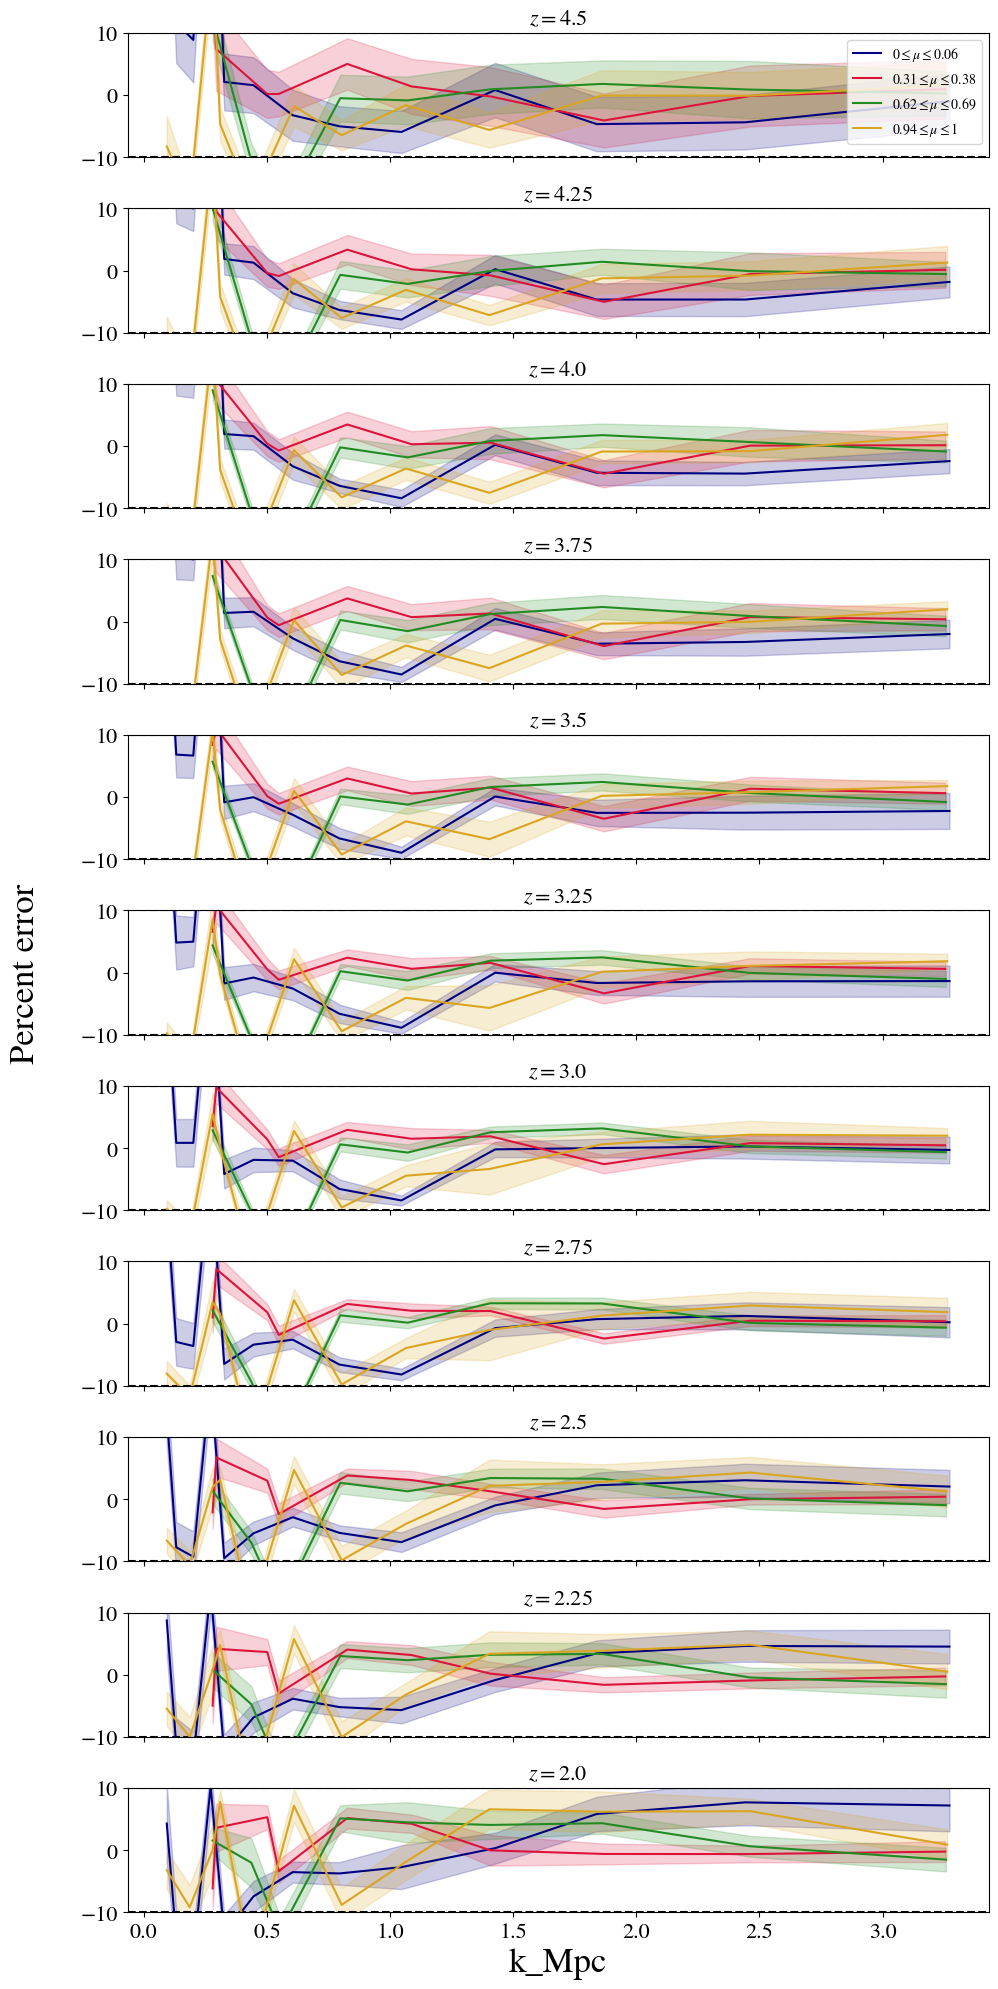

In [14]:
plot_p3d_L1O(fractional_errors_sims, 'Pred2Sim_L1Oz.pdf')

In [15]:
fractional_errors_arinyo_p1d = np.zeros(shape =(Nsim, Nz, 53))
fractional_errors_sims_p1d = np.zeros(shape =(Nsim, Nz, 53))
fractional_errors_bench_p1d = np.zeros(shape =(Nsim, Nz, 53))


for s in range(Nsim):
    for ii,z in enumerate(zs):

        
        fractional_errors_arinyo_p1d[s,ii] = (np.median(p1ds_pred[:,s,ii],0) / p1ds_arinyo[s,ii] - 1)*100
        fractional_errors_sims_p1d[s,ii] = (np.median(p1ds_pred[:,s,ii],0) / p1ds_sims[s,ii] - 1)*100
        fractional_errors_bench_p1d[s,ii] = (p1ds_arinyo[s,ii] / p1ds_sims[s,ii] - 1)*100

                

In [16]:
dict_sim = [d for d in Archive3D.training_data if d['z']==3 and d['sim_label']==f'mpg_4' and d['val_scaling'] ==1]

like = Likelihood(dict_sim[0], Archive3D.rel_err_p3d, Archive3D.rel_err_p1d )
k1d_mask = like.like.ind_fit1d.copy() 
k1d_sim = like.like.data["k1d"][k1d_mask]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


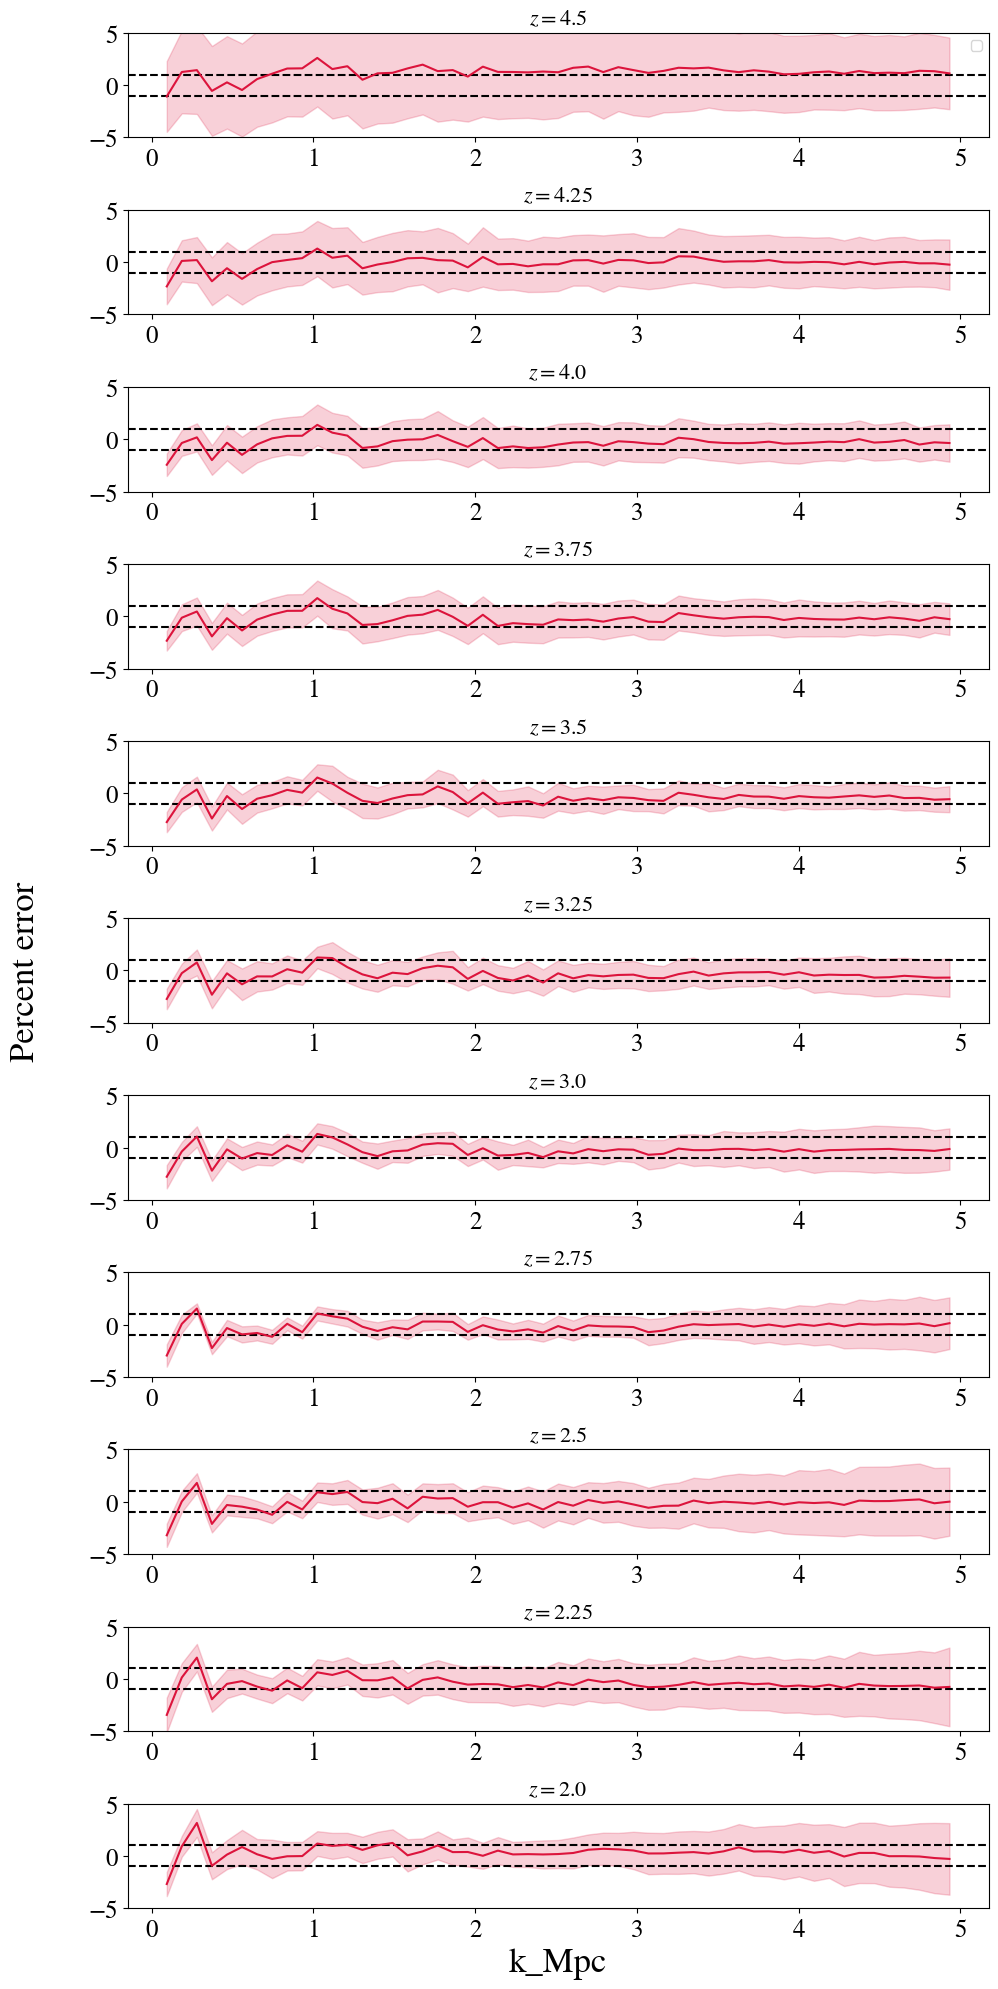

In [17]:
plot_p1d_L1O(fractional_errors_sims_p1d, 'Pred2Sim_L1Oz_P1D.pdf')